In [17]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cosmology
from galaxy_catalog import *
from cosmos import COSMOSCatalog
from cosmos import *
import pickle
# cosmology package is under cosmology.py

In [18]:
# store the COSMOS HST F814W data as a catalog
catalog = COSMOSCatalog('/Users/ruby/Documents/COSMOS_23.5_training_sample')

In [19]:
# Saves data for the model
def save(object, filename):
    with open(filename + '.pickle', 'wb') as f:
        pickle.dump(object, f)

In [20]:
# helper function
def draw_box(x, y, **kwargs):
    """Draw rectangle, given x-y boundary tuples"""
    plt.gca().add_patch(
        matplotlib.patches.Rectangle(
            (x[0], y[0]), x[1] - x[0], y[1] - y[0], facecolor="none", **kwargs
        )
    )

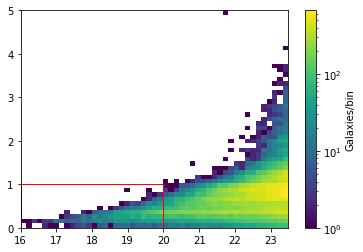

In [21]:
magnitude_range = (16, 20)
redshift_range = (0, 1)
x, y = catalog.catalog['mag_auto'], catalog.catalog['zphot']
plt.hist2d(x, y, bins=(np.linspace(16, 23.5, 50), np.linspace(0, 5, 50)), norm=matplotlib.colors.LogNorm()) 
plt.colorbar(label='Galaxies/bin')
draw_box(magnitude_range, redshift_range, edgecolor='r')

selection_mask = ((magnitude_range[0] <= x) & (x < magnitude_range[1])
                  & (redshift_range[0] <= y) & (y < redshift_range[1]))

                  

In [22]:
print(selection_mask.size)
print(selection_mask)
count = np.count_nonzero(selection_mask)
print(count)

56062
[False False False ... False False False]
2418


### Draw Metadata


In [23]:
n_images = count * 10

md = dict()

# index in the catalog of the galaxy image to use
md['source_index'] = catalog.sample_indices(n_images, selection_mask)

# rotation (in radians) to give the source image
md['source_rotation'] = 2.0 * np.pi * np.random.rand(n_images)

# Einstein radius (in arcseconds) of the lens
md['theta_E'] = np.random.uniform(0.8, 1.2, n_images)

# Exponent of the lens' power-law mass distribution
md['gamma'] = 2.0 + 0.1 * np.random.rand(n_images)

# ellipticity components of the lens
md['e1'], md['e2'] = np.random.uniform(-0.05, 0.05, (2, n_images))

# location of the lens (in arcseconds) in the image
md['center_x'], md['center_y'] = 0.2 * np.random.rand(2, n_images)

# External shear components
md['gamma1'], md['gamma2'] = 0.16 * np.random.rand(2, n_images)

md['fileName'] = np.arange(n_images)

# save this to a csv
csvfile = pd.DataFrame(md)
imageDict = csvfile.to_dict('records')
csvfile.head()
# save the csv file here

,source_index,source_rotation,theta_E,gamma,e1,e2,center_x,center_y,gamma1,gamma2,fileName
0,43309,5.001429,0.854020,2.026982,0.026039,-0.015996,0.115031,0.010383,0.012669,0.007547,0
1,39287,4.748178,0.854966,2.067258,-0.002492,-0.044356,0.110256,0.047073,0.015884,0.093915,1
2,32784,1.643618,1.175890,2.084988,0.038158,0.010378,0.172109,0.141291,0.033425,0.123702,2
3,37799,2.629219,1.126457,2.087138,-0.046031,0.047605,0.049967,0.083221,0.142890,0.104579,3
4,32141,5.508402,0.971638,2.097326,-0.008579,-0.022994,0.071486,0.199727,0.054893,0.029188,4


In [24]:
print(np.unique(md['source_index']).size)

2418


In [25]:
all_indices = np.unique(md['source_index'])

### Produce Images

In [26]:
# two random indices
n = 200
index_val = np.random.choice(all_indices.shape[0], n, replace=False)
val_indices = all_indices[index_val]
new_all_indices = np.delete(all_indices, index_val)
index_test = np.random.choice(new_all_indices.shape[0], n, replace=False)
test_indices = new_all_indices[index_test]
train_indices = np.delete(new_all_indices, index_test)

print("Train: {}, Val: {}, Test: {}".format(train_indices.size, val_indices.size, test_indices.size))


Train: 2018, Val: 200, Test: 200


In [27]:
from lensmaker import *

lens_maker = LensMaker(catalog=catalog, pixel_width=0.08)

In [32]:

plot = True

# create a 'dummy' lens that does not lens at all
no_lens = [('SIS', dict(theta_E=0))]

for i in range(n_images):
    source_kwargs = dict(catalog_i=md['source_index'][i],
                        phi=md['source_rotation'][i])
    
    unlensed_img = lens_maker.lensed_image(lenses=no_lens, **source_kwargs)
    
    lensed_img = lens_maker.lensed_image(lenses=[
        ('SIE', {k: md[k][i] for k in 'theta_E e1 e2 center_x center_y'.split()}),
        ('SHEAR', {k: md[k][i] for k in 'gamma1 gamma2'.split()})], **source_kwargs)
    
    # save to file
    if (md['source_index'][i] in test_indices):
        path = "/Users/ruby/Documents/test"
    elif (md['source_index'][i] in val_indices):
        path = "/Users/ruby/Documents/val"
    else:
        path = "/Users/ruby/Documents/train"
        
    #unlensed_img_name = "{}/Unlensed/{}".format(path, i)
    np.save(path+'/Unlensed/'+str(i), unlensed_img)
    
    #lensed_img_name = "{}/Lensed/{}".format(path, i)
    np.save(path+'/Lensed/'+str(i), lensed_img)
    
    # these images are now just arrays of floats
   
    plot = False
    if plot:
        f, axes = plt.subplots(ncols=2, figsize=(12,4))
        plt.sca(axes[0])
        plot_image(unlensed_img, lens_maker.pixel_width)
        plt.title('Unlensed')
        
        plt.sca(axes[-1])
        plot_image(lensed_img, lens_maker.pixel_width)
        plt.title('Lensed')
        plt.show()
        
      
    

"   \n    plot = False\n    if plot:\n        f, axes = plt.subplots(ncols=2, figsize=(12,4))\n        plt.sca(axes[0])\n        plot_image(unlensed_img, lens_maker.pixel_width)\n        plt.title('Unlensed')\n        \n        plt.sca(axes[-1])\n        plot_image(lensed_img, lens_maker.pixel_width)\n        plt.title('Lensed')\n        plt.show()\n        \n "

### Train/Val/Test Split in CSV files using 'source_id'
We can save the train/val/test split to .csv files with each source's individual source id.

In [33]:
train_file = "/Users/ruby/Documents/train/train_params.csv"
val_file = "/Users/ruby/Documents/val/val_params.csv"
test_file = "/Users/ruby/Documents/test/test_params.csv"

params_val = csvfile.loc[csvfile['source_index'].isin(val_indices)]
params_val.to_csv(val_file, index=False, header=True)

params_test = csvfile.loc[csvfile['source_index'].isin(test_indices)]
params_test.to_csv(test_file, index=False, header=True)

params_train = csvfile.loc[csvfile['source_index'].isin(train_indices)]
params_train.to_csv(train_file, index=False, header=True)

# could save the 'csvfile' to a .npy file here 


In [34]:
params_train

,source_index,source_rotation,theta_E,gamma,e1,e2,center_x,center_y,gamma1,gamma2,fileName
0,43309,5.001429,0.854020,2.026982,0.026039,-0.015996,0.115031,0.010383,0.012669,0.007547,0
1,39287,4.748178,0.854966,2.067258,-0.002492,-0.044356,0.110256,0.047073,0.015884,0.093915,1
2,32784,1.643618,1.175890,2.084988,0.038158,0.010378,0.172109,0.141291,0.033425,0.123702,2
3,37799,2.629219,1.126457,2.087138,-0.046031,0.047605,0.049967,0.083221,0.142890,0.104579,3
4,32141,5.508402,0.971638,2.097326,-0.008579,-0.022994,0.071486,0.199727,0.054893,0.029188,4
...,...,...,...,...,...,...,...,...,...,...,...
24173,9181,2.464594,1.118457,2.079749,-0.026120,0.004159,0.120749,0.009699,0.120605,0.043512,24173
24174,47748,3.876307,1.186976,2.004956,-0.033466,-0.035105,0.000166,0.194274,0.096477,0.015120,24174
24176,10446,2.223867,1.024033,2.027992,0.007728,0.043217,0.168448,0.037518,0.154170,0.018493,24176
24177,50795,3.426419,0.884757,2.097154,0.031485,-0.026498,0.159841,0.076907,0.108484,0.030549,24177


### Visualise Images
First, we'll define some functions to help plot the lensed and unlensed images.

In [45]:
def exporter():
    '''Returns export decorator, __all__ list'''
    all_ = []
    def decorator(obj):
        all_.append(obj.__name__)
        return obj
    return decorator, all_

def image_grid(shape, pixel_width, x0=0, y0=0, edges=True):
    nx, ny = shape
    dx = nx * pixel_width
    dy = nx * pixel_width
    extra = 1 if edges else 0
    x = np.linspace(-dx/2, dx/2, nx + extra) + x0
    y = np.linspace(-dy/2, dy/2, ny + extra) + y0
    return x, y

def plot_image(img, pixel_width, log_scale=True, label="HST F814W", colorbar=True,
              adjust_ax=True, vmin=None, vmax=None, **kwargs):
    
    # set reasonable default settings
    if vmax is None:
        vmax = img.max()
    if vmin is None:
        if log_scale:
            vmin = vmax * 1e-3
        else:
            vmin = img.min()
    kwargs.setdefault("norm", matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax) if log_scale
                      else matplotlib.colors.Normalize(vmin=vmin, vmax=vmax))
    
    kwargs.setdefault("cmap", "magma")
    
    # now plot the image
    plt.pcolormesh(*image_grid(img.shape, pixel_width), img.clip(vmin, None).T, **kwargs)
    if adjust_ax:
        plt.gca().set_aspect("equal")
        
    if colorbar:
        # plot colorbar
        cbar = plt.colorbar(label=label, extend="both")
        cax = cbar.ax
        # format the ticks of the colorbar so they're not of the form 10^x
        cax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%g"))
        if len(cbar.get_ticks()) < 2:
            # if there are only few colorbar ticks, get minor ticks too
            cax.yaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter("%g"))
            cax.tick_params(axis="y", labelsize=7, which="minor")
    
    plt.xlabel("[Arcseconds]")
    plt.ylabel("[Arcseconds]")
    
    
        

In [46]:
datafile = np.load("/Users/ruby/Documents/train/Lensed/24168.npy")
np.amax(datafile)

1.6304888742902544

(64, 64)

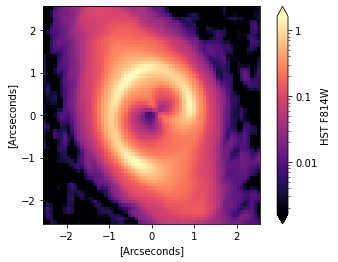

In [47]:
plot_image(datafile, pixel_width=0.08)
datafile.shape

Now, let's visualise the training data.

In [49]:
train_path = "/Users/ruby/Documents/train/Lensed"

import os

train_imgs = [os.path.join(train_path, f) for f in os.listdir(train_path) if
             os.path.isfile(os.path.join(train_path, f)) and f.lower().endswith('.npy')]

print(train_imgs[0])
print(len(train_imgs))


/Users/ruby/Documents/train/Lensed/531.npy
20206


Plot some of the images in the 'Lensed' training data.

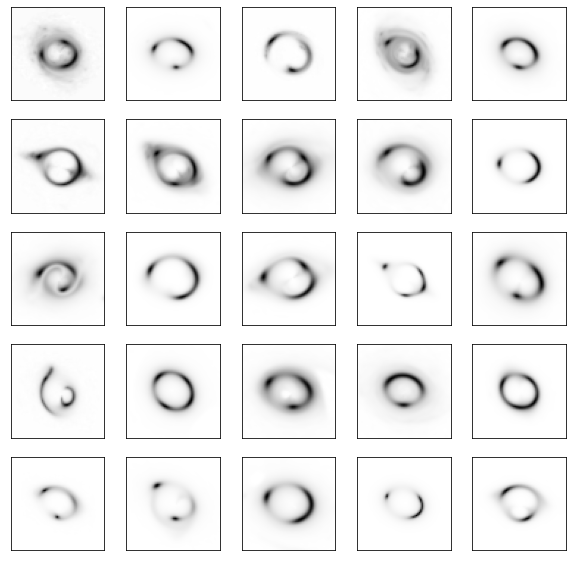

In [52]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # we will need to normalise the images to plot them
    img = np.load(train_imgs[i])/255
    plt.imshow(img, cmap=plt.cm.binary)
plt.show()

In [53]:
print(len(os.listdir("/Users/ruby/Documents/train/Lensed")),
     len(os.listdir("/Users/ruby/Documents/train/Unlensed")))

print(len(os.listdir("/Users/ruby/Documents/val/Lensed")), 
     len(os.listdir("/Users/ruby/Documents/val/Unlensed")))

print(len(os.listdir("/Users/ruby/Documents/test/Lensed")),
     len(os.listdir("/Users/ruby/Documents/test/Unlensed")))

20206 20206
2003 2003
1971 1971


Therefore, we have generated $20206$, $2003$ and $1971$ strong galaxy-galaxy gravitational lenses and non-lenses for training, validation and testing, respectively.